Librerías necesarias:

In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import csv
from PIL import Image
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.metrics import confusion_matrix
#from scipy import stats
#KERAS
import h5py
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from sklearn.metrics import classification_report
import collections
from keras.models import model_from_json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

Leemos el directorio y contamos cuántas imágenes hay

In [2]:
directoris = []
contador = []
fitxers = []
path_img = []

#Devuelve el path a las imágenes (path_img), el nombre de las imágenes (fitxers) y la cantidad (contador)
for dirname, _, filenames in os.walk('/Volumes/Lorena/APTOS/aptos2019-blindness-detection/train_images',followlinks=False):
    directoris.append(os.path.join(dirname))
    for i in filenames:
        if not '._' in i:
            fitxers.append(i)
            path_img.append(dirname+"/"+i)
    contador.append(dirname+': CONTÉ '+str(len(fitxers)) + ' FOTOS')

In [3]:
# Cargamos el train.csv
csv_train = open('/Volumes/Lorena/APTOS/aptos2019-blindness-detection/train.csv')
csvreader = csv.reader(csv_train)
rows = []
for row in csvreader:
        rows.append(row)

Creamos los sets de imágenes y etiquetas

In [4]:
data = []
labels = []
# recorremos los paths de las imágenes y de las filas del csv, buscamos el nombre de la imágen en el
#csv y creamos dos sets de datos con las imágenes y la etiqueta correspondiente en la misma posición
for imagePath in path_img:
    #print(imagePath)
    if not '._' in imagePath:
        for row in rows:
            item = imagePath.split(os.path.sep)[-1]
            if item[0:item.find('.')] in row[0] and item[1]!='_' :
                # leemos la imagen
                image = cv2.imread(imagePath)
                image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
                # creamos los arrays de imágenes y etiquetas
                data.append(image)
                labels.append(row[0][(row[0].find(';'))+1:])

In [5]:
len(data)

3648

Procesamos las imágenes recortando los bordes y aplicando filtro gausiano

In [6]:
#Función que recorta los bordes de las imágenes 
def crop_border(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray_img > 7       
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
        return img
    else:
        img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
        img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
        img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
        img = np.stack([img1,img2,img3],axis=-1)
    return img

In [7]:
processed_data = []
for img in data:
    image = img
    # Cortamos los bordes
    image = crop_border(image)
    image = cv2.resize(image, (256, 256))
    # Aplicamos GaussianBlur
    blurred = cv2.blur(image, ksize=(int(256 / 6), int(256 / 6)))
    image_blur = cv2.addWeighted(image, 4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
    processed_data.append(image_blur)

Balanceamos los datos

In [8]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))


{'0': 1796, '1': 369, '2': 995, '3': 193, '4': 295}

In [9]:
minimo=min(counts)
print("Minimo support: ", minimo) #cogemos el minimo para equiparar la data de cada label

Minimo support:  193


In [10]:
lab_0=0; lab_1=0; lab_2=0; lab_3=0; lab_4=0
ind_0=[]; ind_1=[]; ind_2=[]; ind_3=[]; ind_4=[]

for a in range(len(labels)): #hacemos cinco listas de los indices de cada label de longitud=minimo
    if (labels[a]=='0' and lab_0<minimo):
        lab_0+=1
        ind_0.append(a)
    if (labels[a]=='1' and lab_1<minimo):
        lab_1+=1
        ind_1.append(a)
    if (labels[a]=='2' and lab_2<minimo):
        lab_2+=1
        ind_2.append(a)
    if (labels[a]=='3' and lab_3<minimo):
        lab_3+=1
        ind_3.append(a)
    if (labels[a]=='4' and lab_4<minimo):
        lab_4+=1
        ind_4.append(a)

Creamos los conjuntos de entrenamiento, validación y prueba

In [11]:
data_arr = np.array(processed_data)
labels_arr = np.array(labels)

final = int(minimo*0.8)

#se separa la data en train y test
ind_Train = ind_0[:final] + ind_1[:final] + ind_2[:final] + ind_3[:final] + ind_4[:final] 
ind_Test =  ind_0[final:] + ind_1[final:] + ind_2[final:] + ind_3[final:] + ind_4[final:]

print("Lista train:", len(ind_Train)," test: ", len(ind_Test),"\nTotal lista: ", len(ind_Train)+len(ind_Test), " minimo total:", minimo*5)

Train = ind_Train + ind_Test

Train_Data = data_arr[Train, :, :, :] #Todos los datos (train + test)
Train_Labels = to_categorical(np.array(labels_arr[Train])) #Todos las etiquetas (train + test)

indTrainP = np.random.permutation(ind_Train)
indTestP = np.random.permutation(ind_Test) 
 
       
train_data = data_arr[indTrainP, :, :, :] #Datos con el 80% de los datos (train)
print(type(train_data))
print(np.shape(train_data))
train_labels = to_categorical(np.array(labels_arr[indTrainP])) 
print(type(train_labels))
print(np.shape(train_labels))
test_data = data_arr[indTestP, :, :, :] #Datos con el 20% de los datos (test)
test_labels = to_categorical(np.array(labels_arr[indTestP])) #etiquetas de test codificadas (x,4)
print("Shape of labels", train_labels.shape, "shape of data train", train_data.shape, "shape of test train", test_data.shape)

Lista train: 770  test:  195 
Total lista:  965  minimo total: 965
<class 'numpy.ndarray'>
(770, 256, 256, 3)
<class 'numpy.ndarray'>
(770, 5)
Shape of labels (770, 5) shape of data train (770, 256, 256, 3) shape of test train (195, 256, 256, 3)


In [12]:
#Para comprobar que el número es el mismo
counterT=collections.Counter(np.argmax(test_labels,axis=1))
print("counter test", counterT)

counterTR=collections.Counter(np.argmax(train_labels,axis=1))
print("counter train", counterTR)

counter test Counter({1: 39, 4: 39, 2: 39, 0: 39, 3: 39})
counter train Counter({3: 154, 0: 154, 2: 154, 1: 154, 4: 154})


Creamos el modelo y entrenamos

In [13]:
# Modelo en red preentrenada
base_model = VGG16(input_shape = (256, 256, 3), # El tamaño de nuestras imágenes
include_top = False, # Quitamos la última capa totalmente conectada
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

# Aplanamos la capa de salida del modelo a una sola dimension
x = layers.Flatten()(base_model.output)

# Añadimos una capa totalmente conectada con 1024 neuronas y una activación ReLU
x = layers.Dense(1024, activation='relu')(x)

# Añadimos una dropout de 0.5
x = layers.Dropout(0.5)(x)

# Añadimos una capa densa con una activación softmax para que de un vector de probabilidades en la salida por cada clase
x = layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

2022-05-27 13:05:17.731957: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Se entrena con un optimizador Adam, con un ratio de apredizaje de 0.001 y un batch size de 100, ya que se ha validado que son los hiperparámetros que dan mejores resultados

In [14]:
# Definimos el criterio de early stopping
pat = 5 # Este es el número de épocas sin mejora después de las cuales el entrenamiento parará
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Definimos el checkpoint callback del modelo 
model_checkpoint = ModelCheckpoint('Final_VGG16.h5', verbose=1, save_best_only=True)
history = []
score = []
score_history = []
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS, BATCH_SIZE):
    model.compile(optimizer=Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy']) 
    vgg = model.fit(t_x, t_y, epochs = EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1) 
    
    print("Val Score: ", model.evaluate(val_x, val_y))
    score.append(model.evaluate(val_x, val_y)[1])
    return vgg, score

#n_folds=10
epochs=100
batch_size=100

t_x, val_x, t_y, val_y = train_test_split(train_data, train_labels, test_size=0.1, 
                                           random_state = np.random.randint(1,1000, 1)[0])

model_history, score_hist = fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size)
print("======="*12, end="\n\n\n")
history.append(model_history)
score_history.append(score_hist)

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-05-27 13:05:22.371045: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
7/7 [==============================] - 111s 15s/step - loss: 170.5691 - accuracy: 0.2408 - val_loss: 87.6766 - val_accuracy: 0.4571

Epoch 00001: val_loss improved from inf to 87.67659, saving model to Final_VGG16.h5
Epoch 2/100
7/7 [==============================] - 109s 16s/step - loss: 62.5991 - accuracy: 0.5120 - val_loss: 41.1906 - val_accuracy: 0.5571

Epoch 00002: val_loss improved from 87.67659 to 41.19064, saving model to Final_VGG16.h5
Epoch 3/100
7/7 [==============================] - 109s 16s/step - loss: 28.7612 - accuracy: 0.6260 - val_loss: 18.2935 - val_accuracy: 0.5286

Epoch 00003: val_loss improved from 41.19064 to 18.29353, saving model to Final_VGG16.h5
Epoch 4/100
7/7 [==============================] - 110s 16s/step - loss: 11.1242 - accuracy: 0.6998 - val_loss: 10.2027 - val_accuracy: 0.6000

Epoch 00004: val_loss improved from 18.29353 to 10.20272, saving model to Final_VGG16.h5
Epoch 5/100
7/7 [==============================] - 113s 16s/step - loss:

Observamos los resultados del error y la precisión durante todas las épocas

In [15]:
def acc_plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train_acc', 'Val_acc'], loc='upper left')
    plt.show()
    
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend(['Train_loss', 'Val_loss'], loc='upper left') 
    plt.show()

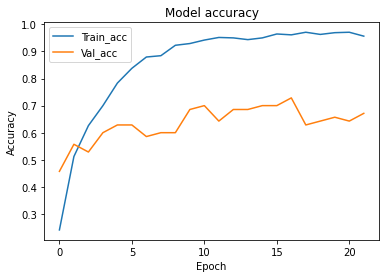

In [16]:
acc_plot(model_history)

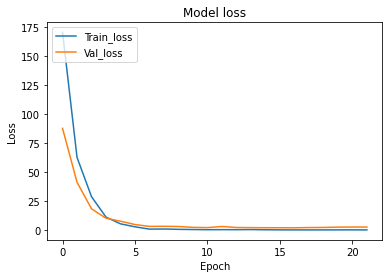

In [17]:
loss_plot(model_history)